# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [2]:
dtype_train = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}

In [3]:
## print out the first 5 rows of each dataset
holidays0 = pd.read_csv(
    "./data/holidays_events.csv"
    , dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    }
    , parse_dates=['date']
    , infer_datetime_format=True)
holidays0 = holidays0.set_index('date').to_period('D')

oil0 = pd.read_csv("./data/oil.csv")
stores0 = pd.read_csv("./data/stores.csv")

train0 = pd.read_csv("./data/train.csv"
                     ,dtype=dtype_train
                     ,parse_dates=['date']
                     ,infer_datetime_format=True)
train0 = train0.set_index('date').to_period('D')
train0 = train0.set_index(['store_nbr', 'family'], append=True)

transactions0 = pd.read_csv("./data/transactions.csv")
test0 = pd.read_csv("./data/test.csv")

In [4]:
average_sales = train0.groupby('date').sales.mean().to_frame()

In [5]:
plot_params = {'color': '0.75',
 'style': '.-',
 'markeredgecolor': '0.25',
 'markerfacecolor': '0.25',
 'legend': False,
 'figsize': (12, 4)}

C:\Users\Juan\AppData\Local\Temp\ipykernel_17292\3955807847.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(average_sales.index.astype(str), rotation=45)


Text(0.5, 1.0, 'Time Plot of average Sales')

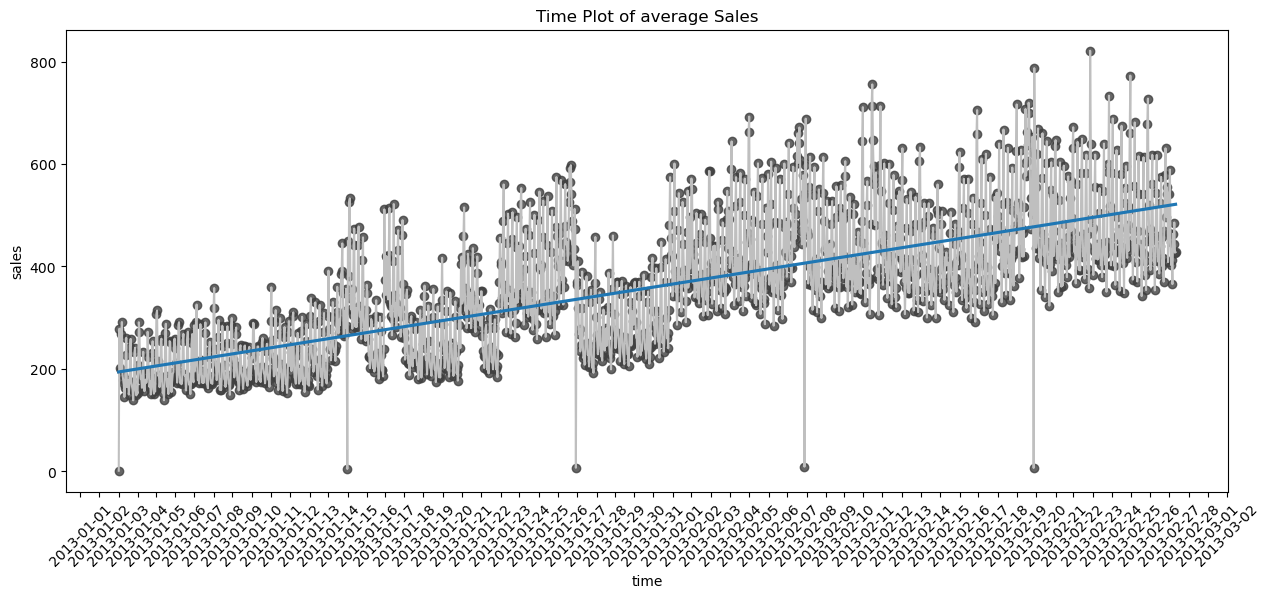

In [6]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)

# plot sales data
average_sales['time'] = np.arange(len(average_sales))
ax.plot('time', 'sales', data=average_sales, color='0.75')

# format x-axis
ax.set_xticklabels(average_sales.index.astype(str), rotation=45)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# add regression line
ax = sns.regplot(x='time', y='sales', data=average_sales, ci=None, scatter_kws=dict(color='0.25'))

ax.set_title('Time Plot of average Sales')

# Create base regression model

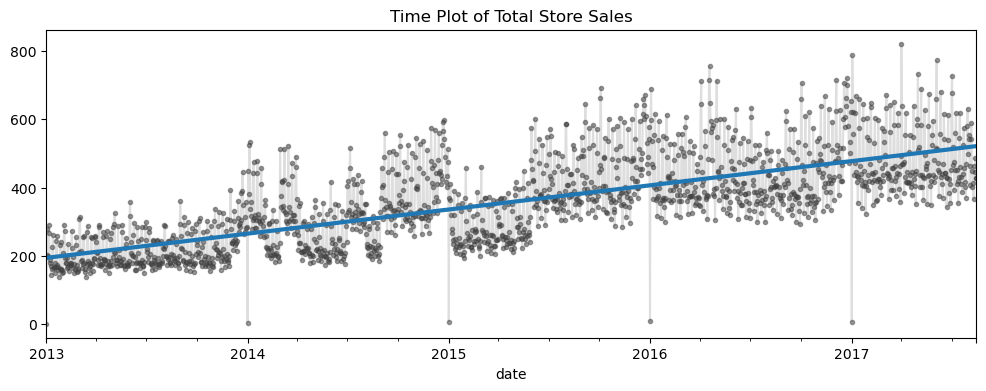

In [7]:
from sklearn.linear_model import LinearRegression

# 
X = average_sales.drop(['sales'], axis=1)  # features
y = average_sales['sales']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(**plot_params, alpha=0.5)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Total Store Sales');

# Lagged sales plot

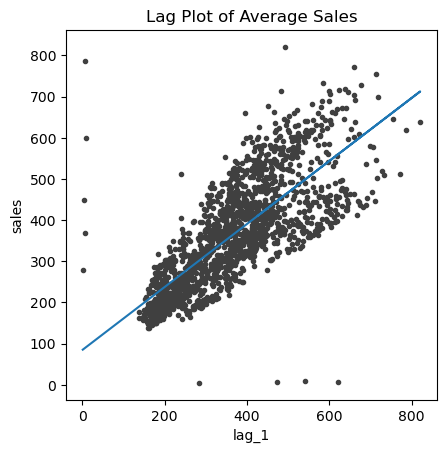

In [8]:
# fit linear regression to lagged sales data
average_sales['lag_1'] = average_sales['sales'].shift(1)

X = average_sales.loc[:, ['lag_1']].dropna()  # features
y = average_sales.loc[X.index, 'sales']  # target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

# plot results
fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.', color='0.25')
ax.plot(X['lag_1'], y_pred)
ax.set(aspect='equal', ylabel='sales', xlabel='lag_1', title='Lag Plot of Average Sales');

In [9]:
average_sales.drop(['lag_1', 'time'], axis=1, inplace=True)

# Trend analysis

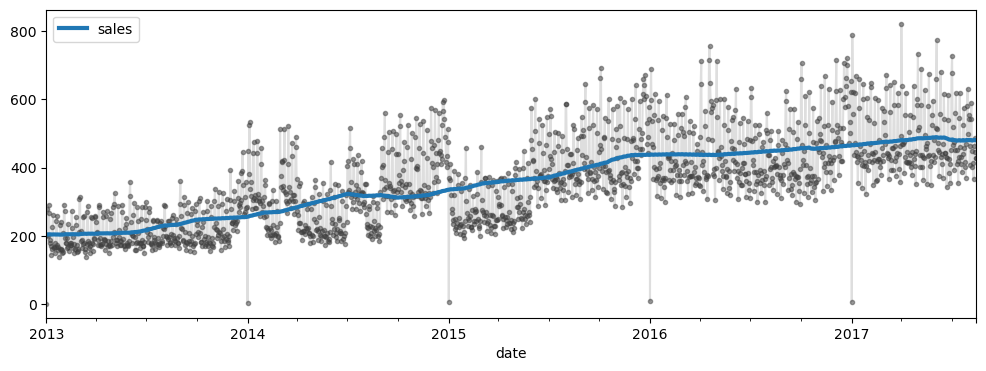

In [10]:
trend = average_sales.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

ax = average_sales.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

starts with increasing upwards trend, then starts decreasing upwards trend. Polynomial of 3rd degree seems worth pursuing

## 3rd degree polynomial regression

In [11]:
from statsmodels.tsa.deterministic import DeterministicProcess

y = average_sales['sales'].copy()  # the target

# Instantiate `DeterministicProcess`
# appropriate for a cubic trend model
dp = DeterministicProcess(index=y.index,  order=3, drop=True)

# Create the feature set for the dates given in y.index
X = dp.in_sample()

# Create features for a 90-day forecast.
X_fore = dp.out_of_sample(steps=90)

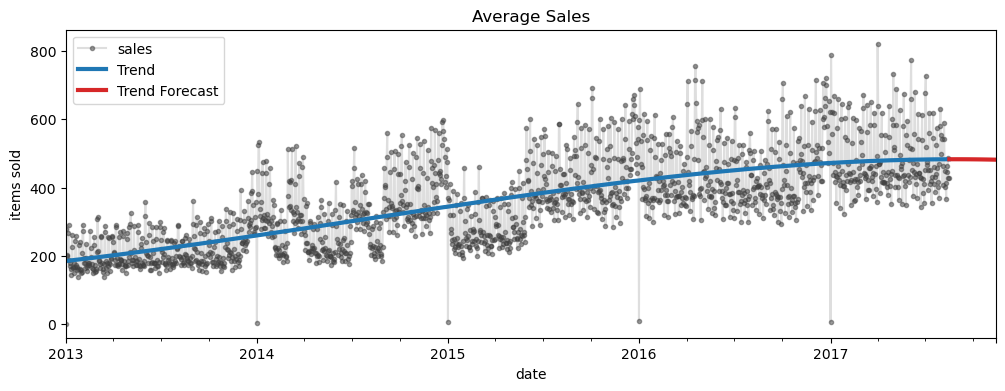

In [12]:
# plot Linear Regression with trend
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend()

## py-earth for spline regression

In [13]:
from pyearth import Earth


c:\Users\Juan\Anaconda3\envs\kaggle-env\lib\site-packages\pyearth\earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
c:\Users\Juan\Anaconda3\envs\kaggle-env\lib\site-packages\pyearth\earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


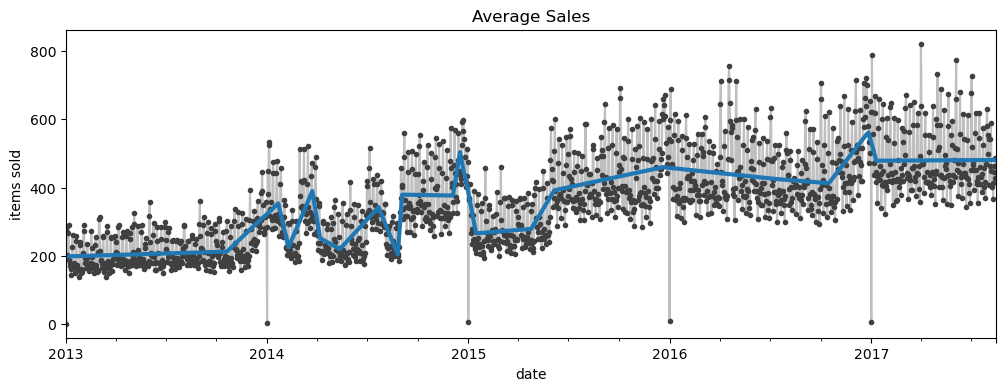

In [14]:

# Target and features are the same as before
y = average_sales['sales'].copy()
dp = DeterministicProcess(index=y.index, order=1)
X = dp.in_sample()

# Fit a MARS model with `Earth`
model = Earth()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(**plot_params, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend")

<Axes: title={'center': 'Detrended Average Sales'}, xlabel='date'>

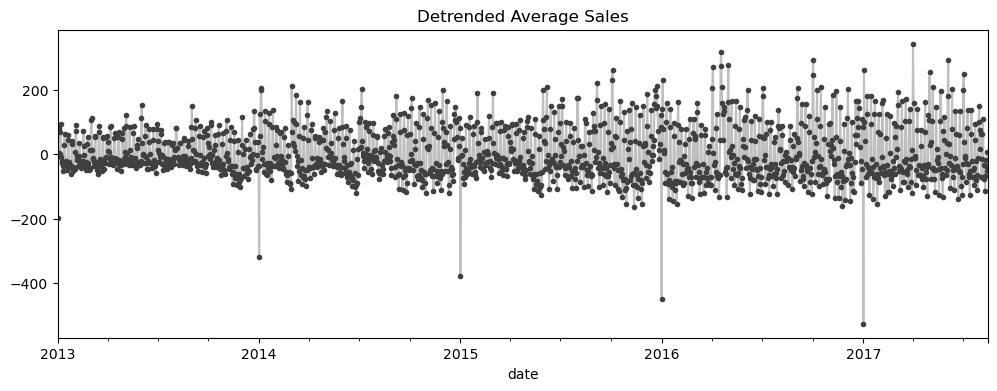

In [15]:
y_detrended = y - y_pred   # remove the trend from store_sales

y_detrended.plot(**plot_params, title="Detrended Average Sales")

# Season analysis

In [16]:
from scipy.signal import periodogram

In [17]:
X = average_sales['sales'].loc['2017'].to_frame()

In [18]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots(figsize=(16, 4))
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    
    return ax

In [19]:
X["week"] = X.index.week
X["day"] = X.index.dayofweek
# seasonal_plot(X, y='sales', period='week', freq='day');
# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
# fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))

C:\Users\Juan\AppData\Local\Temp\ipykernel_17292\3948323306.py:3: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1D")


<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

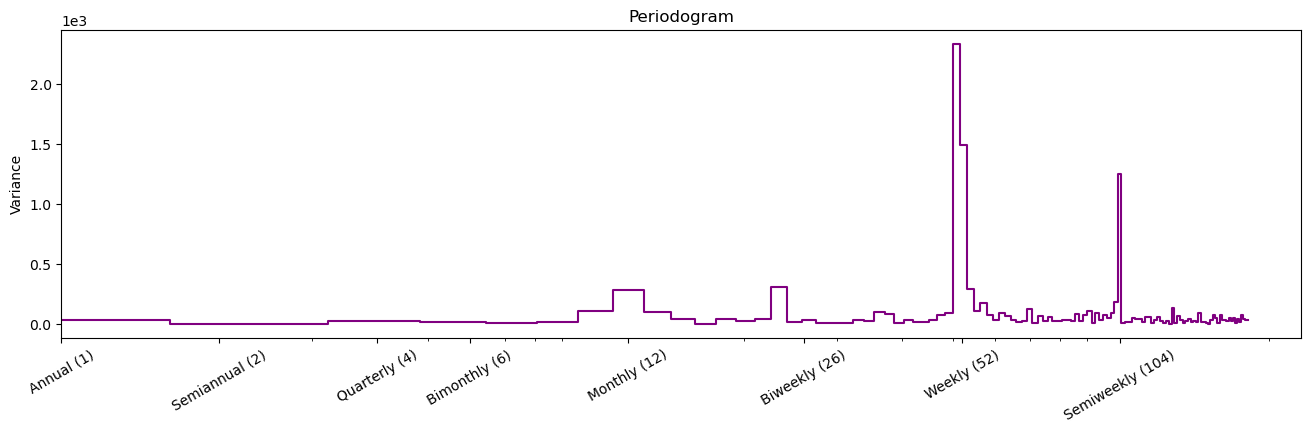

In [20]:
plot_periodogram(X['sales'])

the periodogram shows strong weekly seasonality. Next we create fourier features to add seasonality to the training data.

In [21]:
from statsmodels.tsa.deterministic import CalendarFourier
y = average_sales['sales'].loc['2017'].copy()

fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()

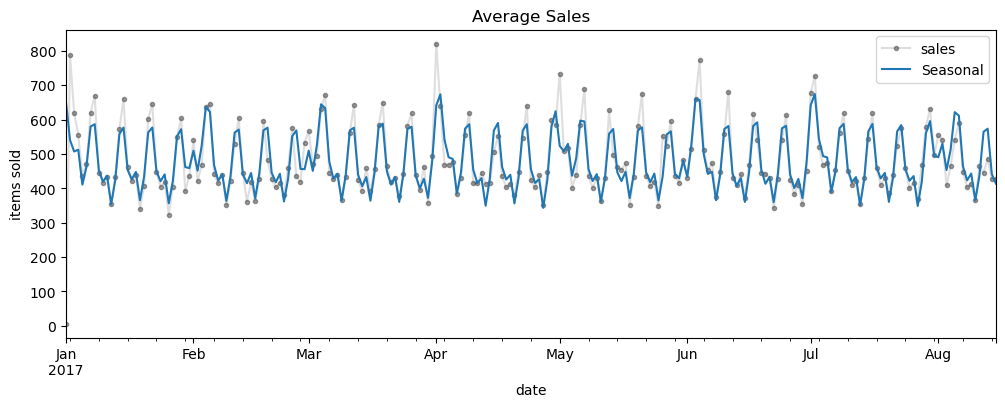

In [22]:
model = LinearRegression().fit(X, y)
y_pred = pd.Series(
    model.predict(X),
    index=X.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X), index=X.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend()

C:\Users\Juan\AppData\Local\Temp\ipykernel_17292\3948323306.py:3: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1D")


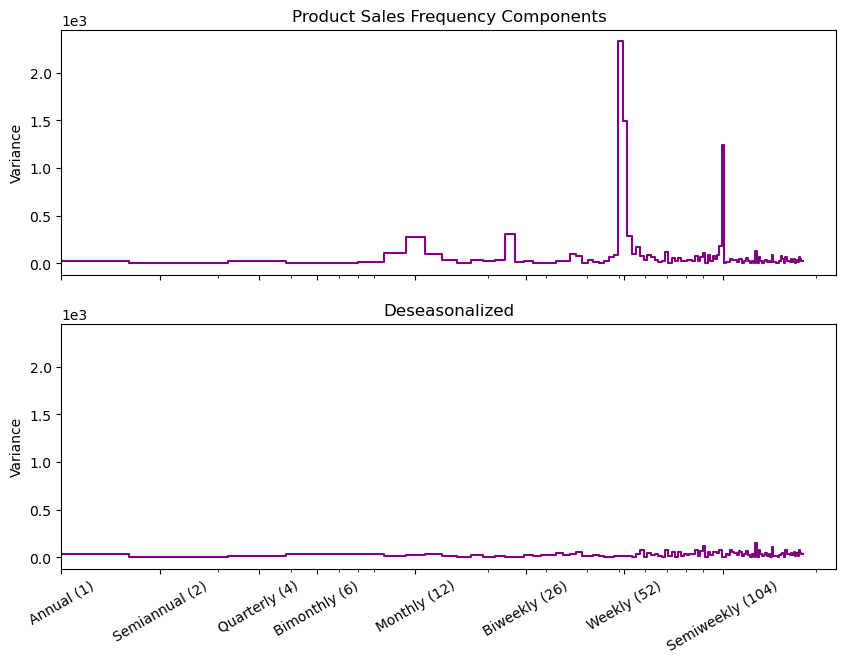

In [23]:
# detrend/deseasonalize the data and visualize the updated periodogram

y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

seasonality greatly reduced. This can be observed in the lack of large values in the periodogram

In [24]:
# how do holidays affect our predictions?
# National and regional holidays in the training set
holidays = (
    holidays0
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

display(holidays)

,description
date,
2017-01-01,Primer dia del ano
2017-01-02,Traslado Primer dia del ano
2017-02-27,Carnaval
2017-02-28,Carnaval
2017-04-01,Provincializacion de Cotopaxi
2017-04-14,Viernes Santo
2017-05-01,Dia del Trabajo
2017-05-13,Dia de la Madre-1
2017-05-14,Dia de la Madre


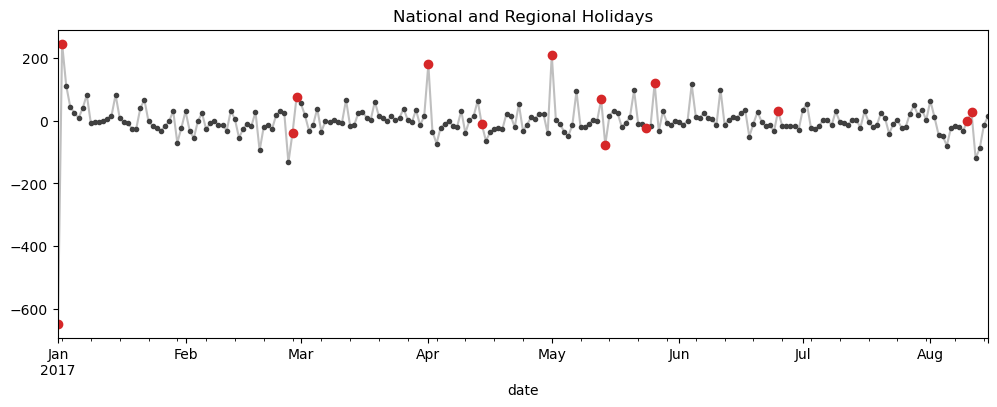

In [25]:
ax = y_deseason.plot(**plot_params)
plt.plot_date(holidays.index, y_deseason[holidays.index], color='C3')
ax.set_title('National and Regional Holidays');

looks like holidays explain various outliers in our data

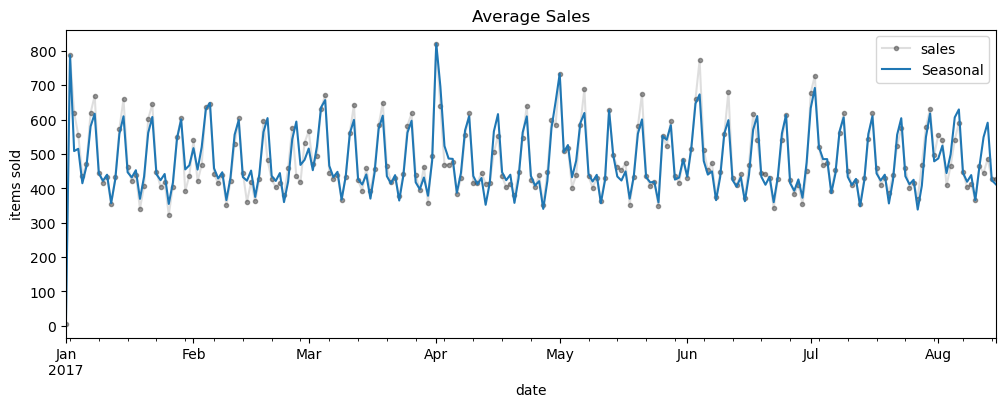

In [26]:
# adding dummies to features and fit new linear regression
X_holidays = pd.get_dummies(holidays)

X2 = X.join(X_holidays, on='date').fillna(0.0)

model = LinearRegression().fit(X2, y)
y_pred = pd.Series(
    model.predict(X2),
    index=X2.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X2), index=X2.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

## 1st SUBMISSION

In [27]:
train0['sales']

date        store_nbr  family                    
2013-01-01  1          AUTOMOTIVE                       0.000000
                       BABY CARE                        0.000000
                       BEAUTY                           0.000000
                       BEVERAGES                        0.000000
                       BOOKS                            0.000000
                                                        ...     
2017-08-15  9          POULTRY                        438.132996
                       PREPARED FOODS                 154.552994
                       PRODUCE                       2419.729004
                       SCHOOL AND OFFICE SUPPLIES     121.000000
                       SEAFOOD                         16.000000
Name: sales, Length: 3000888, dtype: float32

In [28]:
y = train0['sales'].to_frame().unstack(['store_nbr', 'family']).loc["2017"]

# Create training data
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()
X['NewYear'] = (X.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

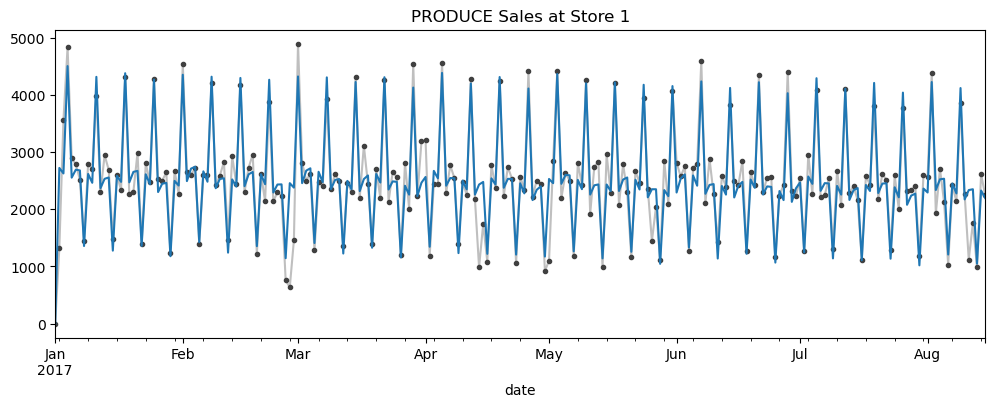

In [29]:
STORE_NBR = '1'  # 1 - 54
FAMILY = 'PRODUCE'
# Uncomment to see a list of product families
# display(train0.index.get_level_values('family').unique())

ax = y.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(**plot_params)
ax = y_pred.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax)
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');

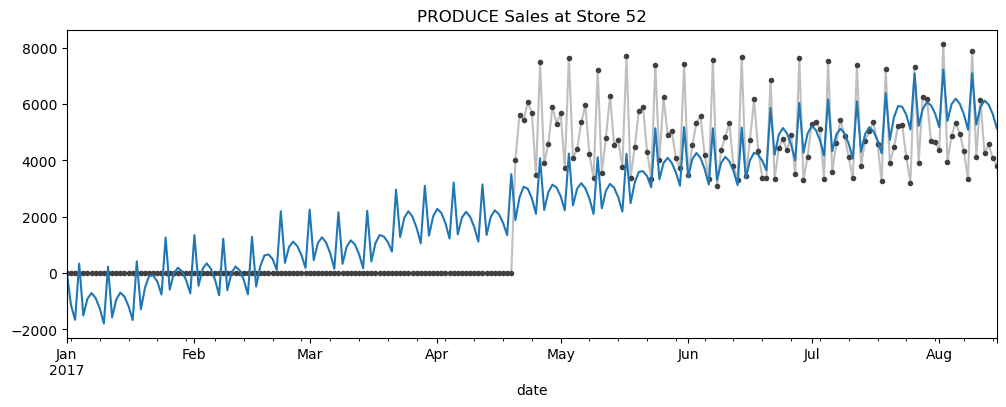

In [30]:
STORE_NBR = '52'  # 1 - 54
FAMILY = 'PRODUCE'

ax = y.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(**plot_params)
ax = y_pred.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax)
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');

0 sales April and earlier make for unaccurate predictions

In [31]:
df_test = pd.read_csv(
    'data/test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

# Create features for test set
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'
X_test['NewYear'] = (X_test.index.dayofyear == 1)



y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
y_submit = y_submit.stack(['store_nbr', 'family'])

y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission.csv', index=False)

Score: 0.5190
(lower is better)

# Serial dependence

In [32]:
family_sales = (
    train0
    .groupby(['family', 'date'])
    .mean() 
    .unstack('family')
    .loc['2017', ['sales', 'onpromotion']]
)

deseason sales variable to search for non-seasonal cyclic patterns.

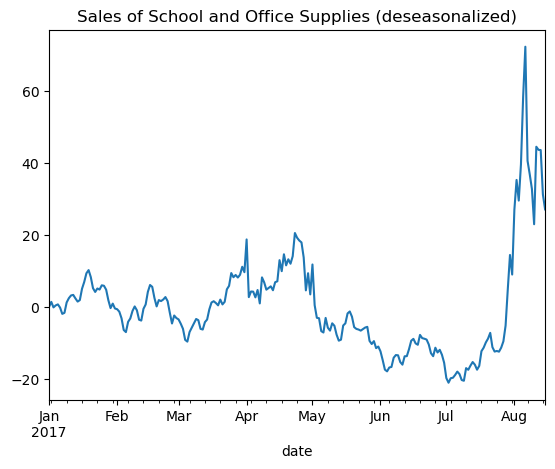

In [33]:
supply_sales = family_sales.loc(axis=1)[:, 'SCHOOL AND OFFICE SUPPLIES']
y = supply_sales.loc[:, 'sales'].squeeze()

fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    constant=True,
    index=y.index,
    order=1,
    seasonal=True,
    drop=True,
    additional_terms=[fourier],
)
X_time = dp.in_sample()
X_time['NewYearsDay'] = (X_time.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X_time, y)
y_deseason = y - model.predict(X_time)
y_deseason.name = 'sales_deseasoned'

ax = y_deseason.plot()
ax.set_title("Sales of School and Office Supplies (deseasonalized)");

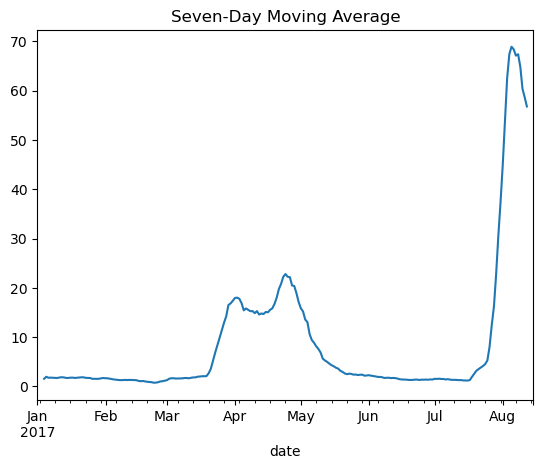

In [34]:
# YOUR CODE HERE
y_ma = y.rolling(7,center=True).mean()


# Plot
ax = y_ma.plot()
ax.set_title("Seven-Day Moving Average");

In [72]:
for lag, ax in zip(range(-3, 3+1), axes.ravel())

In [76]:
len(range(-3, 3+1))

7

In [94]:
def plot_lags(y, x=[],lags = 8, leads=-1,nrows = 3):
    if len(x)==0:
        x = y
    fig, axes = plt.subplots(nrows, -(len(range(-leads, lags+1))//-nrows), figsize=(15, 15*nrows//-(len(range(-leads, lags+1))//-nrows)), sharex=True, sharey=True)
    for lag, ax in zip(range(-leads, lags+1), axes.ravel()):
        y_lagged = x.shift(lag)
        ax.scatter(y_lagged, y, s=1)
        ax.set_title(f"{'Lead' if leads>-1 else 'Lag'} {abs(lag)}")
        ax.set_xlabel(f"lagged {y_lagged.name}")
        ax.set_ylabel(f"{y.name}")

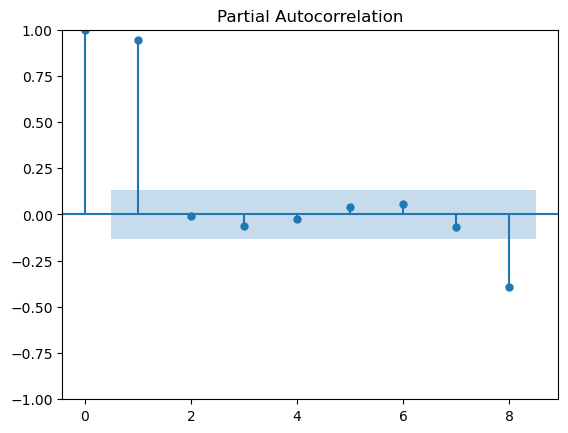

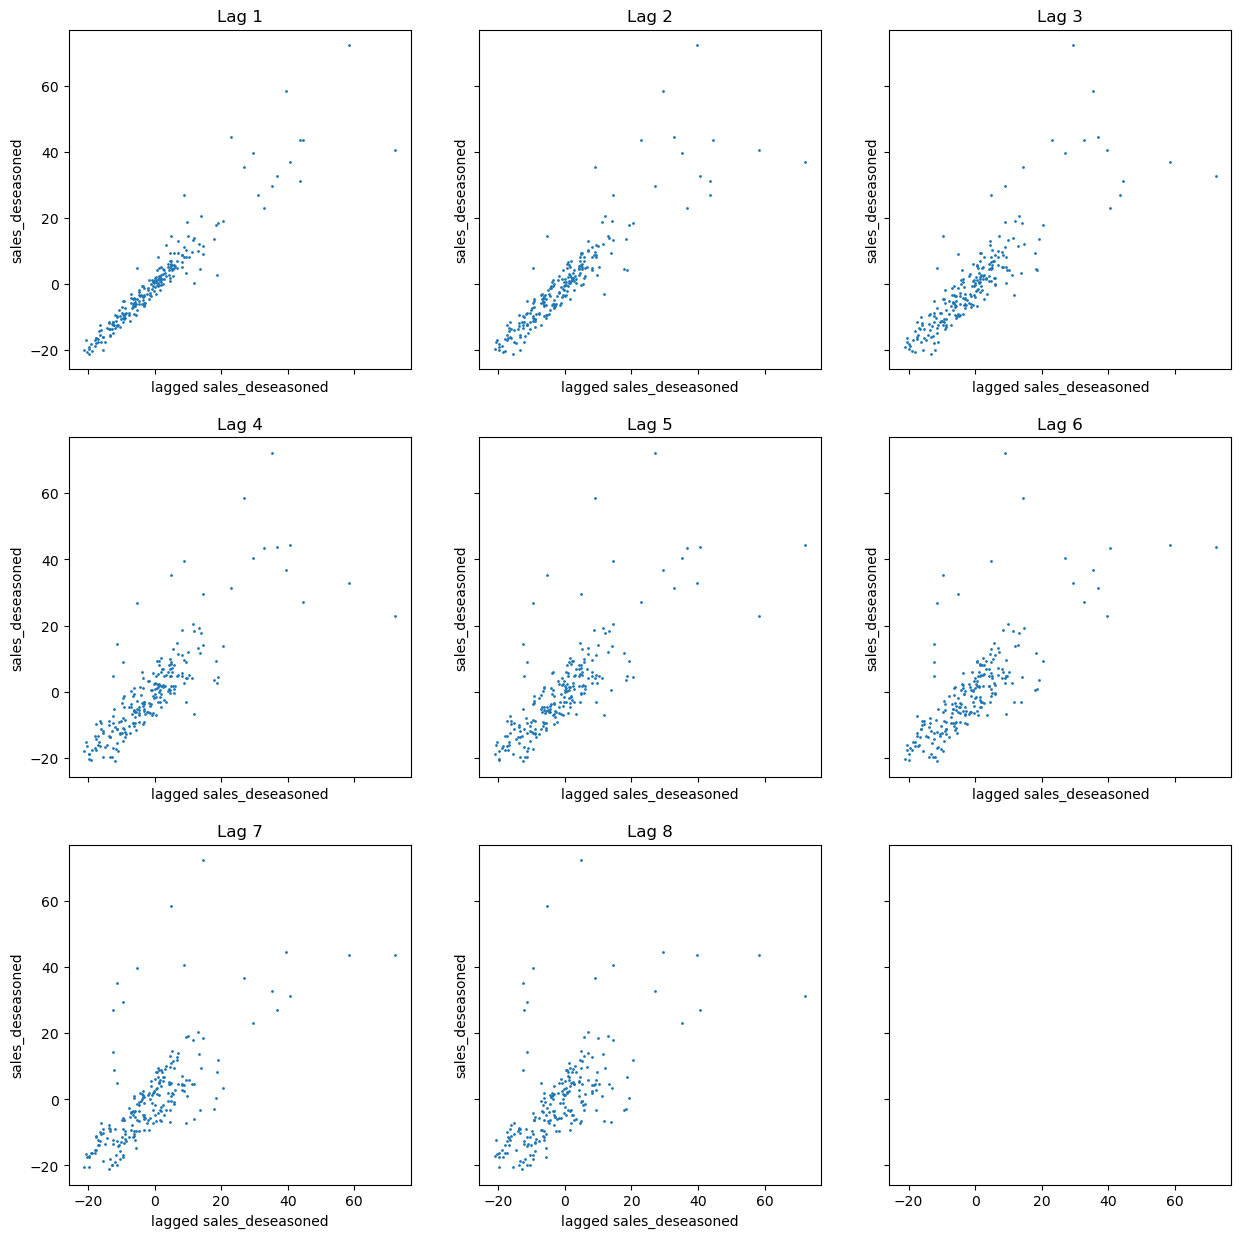

In [95]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(y_deseason, lags=8)

# create subplots that graph the relation between y and lagged values of y
# add red non linear trend lines to the plots

plot_lags(y_deseason)

In [59]:
supply_sales.loc[:, 'onpromotion'].squeeze().rename('onpromotion')

date
2017-01-01    0.000000
2017-01-02    0.000000
2017-01-03    0.000000
2017-01-04    0.000000
2017-01-05    0.000000
                ...   
2017-08-11    2.666667
2017-08-12    2.759259
2017-08-13    2.777778
2017-08-14    2.851852
2017-08-15    2.740741
Freq: D, Name: onpromotion, Length: 227, dtype: float64

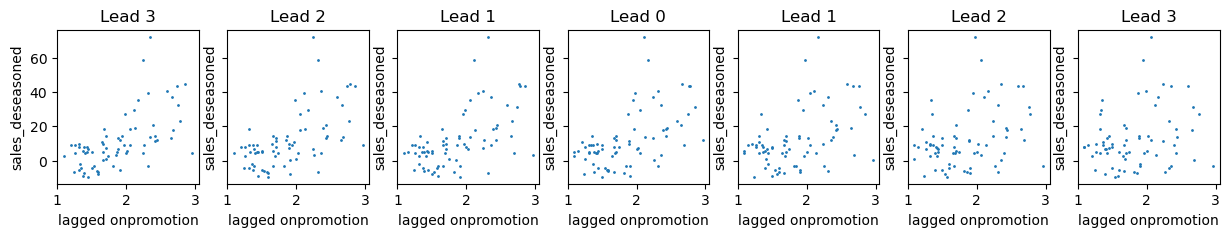

In [96]:
onpromotion = supply_sales.loc[:, 'onpromotion'].squeeze().rename('onpromotion')

# Drop days without promotions
plot_lags(x=onpromotion.loc[onpromotion > 1], y=y_deseason.loc[onpromotion > 1], lags=3, leads=3, nrows=1)

In [98]:
def make_lags(ts, lags, lead_time=1, name='y'):
    return pd.concat(
        {
            f'{name}_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)


def make_leads(ts, leads, name='y'):
    return pd.concat(
        {f'{name}_lead_{i}': ts.shift(-i)
         for i in reversed(range(leads))},
        axis=1)

In [99]:
X_lags = make_lags(y_deseason, lags=1)

X_promo = pd.concat([
    make_lags(onpromotion, lags=1),
    onpromotion,
    make_leads(onpromotion, leads=1),
], axis=1)